Archivo jupyter con preprocesamiento de datos y modelo de entrenamiento


In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 35.6 MB/s eta 0:00:00
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  Fi

In [2]:
#| export
from fastai.vision.all import *
from fastai.vision.widgets import *
import timm
transforms = aug_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

rodajas_augmentation = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    get_y=parent_label, #etiquetamos segun el nombre de la carpeta que los contiene
    item_tfms=Resize(128),
    batch_tfms=transforms,
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

In [4]:

timm.list_models() #modelos disponibles

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw

En la siguiente celda creamos los directorios

In [ ]:
!mkdir data_etiquetada
!mv dataset/PlanoX/RotacionXY/Angulo0 data_etiquetada/PlanoX_0
!mv dataset/PlanoY/RotacionXY/Angulo0 data_etiquetada/PlanoY_0
!mv dataset/PlanoZ/RotacionXY/Angulo0 data_etiquetada/PlanoZ_0

In [5]:
#| export
data_loader_rodajas = rodajas_augmentation.dataloaders("/storage/data_etiquetada/")

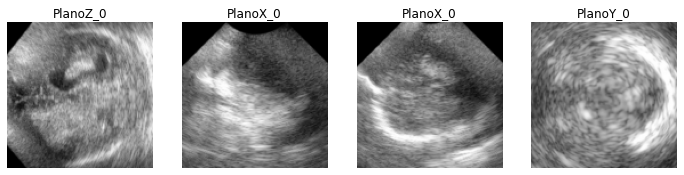

In [6]:
#| export
data_loader_rodajas.valid.show_batch(max_n=4, nrows=1)

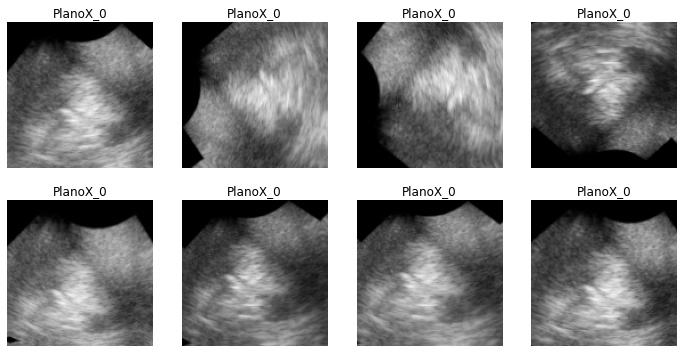

In [7]:
data_loader_rodajas.train.show_batch(max_n=8, nrows=2, unique=True)

visualizamos el modelo entrenado para ver donde se confunde más y comete errores

In [8]:
# | export
learn = vision_learner(data_loader_rodajas, "convnext_tiny_in22k", metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.975506,1.163395,0.221311,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.185356,0.074871,0.032787,00:08
1,0.121679,0.005780,0.000000,00:07
2,0.089378,0.002046,0.000000,00:07
3,0.071552,0.001326,0.000000,00:08


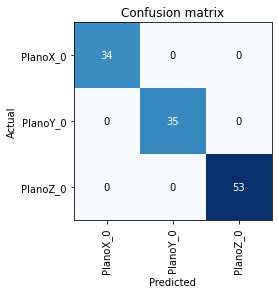

In [9]:
# | export
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

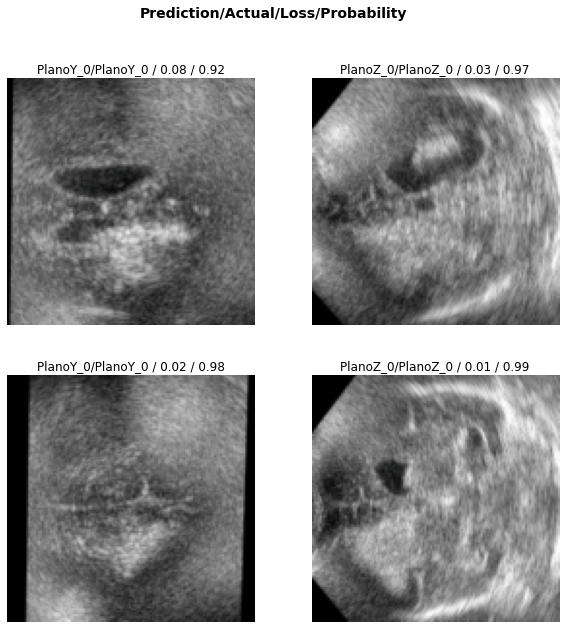

In [10]:
# | export
interp.plot_top_losses(4,figsize=(10, 10))

In [11]:
# | export
cleaner = ImageClassifierCleaner(learn)
cleaner

In [12]:
!pip install -Uqq fastai

In [13]:
# | export
learn.export("modelo_convnext.pkl")

In [17]:

m= learn.model
m

Sequential(
  (0): TimmBody(
    (model): ConvNeXt(
      (stem): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=96, out_features=384, bias=True)
                (act): GELU()
                (drop1): Dropout(p=0.0, inplace=False)
                (fc2): Linear(in_features=384, out_features=96, bias=True)
                (drop2): Dropout(p=0.0, inplace=False)
              )
              (drop_path): Identity()
            )
            (1): ConvNeXtBlock(
              (conv_dw): Conv2d(96, 